In [1]:
import connectorx as cx
import pandas as pd
import numpy as np
import os
import duckdb
from datetime import datetime
import glob
import multiprocessing as mp
from functools import partial
import time

In [2]:
def extract_extreme_bid_prices(trading_date):
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    order_pth = f"/data/HighFreqData/Order/l2order/{date_str}.parquet"
    
    conn = duckdb.connect(database=':memory:')
    
    # 提取主交易时段(1000-1430)的买方订单原始数据
    query = f"""
    SELECT 
        security_code,
        order_price,
        order_volume,
        order_time
    FROM '{order_pth}'
    WHERE order_type = 'A'
        AND order_details = 'L'
        AND order_side = 1
        AND order_time >= 100000000 
        AND order_time < 143000000
    """
    
    orders_df = conn.execute(query).fetchdf()
    conn.close()
    
    return orders_df


In [ ]:
def analyze_extreme_prices(orders_df):
    # 按股票分组计算统计量
    stats_df = orders_df.groupby('security_code').agg({
        'order_price': ['min', 'max', 'mean', 'std', 'count', 
                        lambda x: x.quantile(0.01), 
                        lambda x: x.quantile(0.99)]
    }).reset_index()
    
    # 重命名列
    stats_df.columns = ['security_code', 'min_price', 'max_price', 'mean_price', 
                        'std_price', 'order_count', 'q01_price', 'q99_price']
    
    # 计算极值比例
    stats_df['price_range_ratio'] = stats_df['max_price'] / stats_df['min_price']
    stats_df['max_to_mean_ratio'] = stats_df['max_price'] / stats_df['mean_price']
    stats_df['mean_to_min_ratio'] = stats_df['mean_price'] / stats_df['min_price']
    
    return stats_df



def identify_extreme_orders(orders_df, z_threshold=5):
    # 按股票分组
    results = []
    
    for code, group in orders_df.groupby('security_code'):
        # 计算对数价格
        log_prices = np.log(group['order_price'])
        
        # 计算Z分数
        mean_log_price = log_prices.mean()
        std_log_price = log_prices.std()
        z_scores = (log_prices - mean_log_price) / std_log_price
        
        # 识别极端订单
        extreme_orders = group[abs(z_scores) > z_threshold].copy()
        if not extreme_orders.empty:
            extreme_orders['z_score'] = z_scores[abs(z_scores) > z_threshold].values
            extreme_orders['log_price'] = log_prices[abs(z_scores) > z_threshold].values
            extreme_orders['mean_log_price'] = mean_log_price
            extreme_orders['std_log_price'] = std_log_price
            results.append(extreme_orders)
    
    if results:
        return pd.concat(results)
    else:
        return pd.DataFrame()



In [ ]:
def visualize_price_distributions(orders_df, sample_stocks=5):
    # 随机选择几只股票
    stock_codes = orders_df['security_code'].unique()
    if len(stock_codes) > sample_stocks:
        selected_stocks = np.random.choice(stock_codes, sample_stocks, replace=False)
    else:
        selected_stocks = stock_codes
    
    # 为每只股票创建价格分布图
    for code in selected_stocks:
        stock_orders = orders_df[orders_df['security_code'] == code]
        
        plt.figure(figsize=(12, 6))
        
        # 主图：价格分布直方图
        plt.subplot(121)
        plt.hist(stock_orders['order_price'], bins=50, alpha=0.7)
        plt.title(f'股票 {code} 买单价格分布')
        plt.xlabel('价格')
        plt.ylabel('频次')
        
        # 次图：对数价格QQ图
        plt.subplot(122)
        stats.probplot(np.log(stock_orders['order_price']), dist="norm", plot=plt)
        plt.title(f'股票 {code} 对数买单价格QQ图')
        
        plt.tight_layout()
        plt.show()




def analyze_extreme_price_timing(extreme_orders_df):
    # 将order_time转换为可读时间格式
    extreme_orders_df['readable_time'] = extreme_orders_df['order_time'].apply(
        lambda x: f"{str(x)[:2]}:{str(x)[2:4]}:{str(x)[4:6]}"
    )
    
    # 按时间段统计极端订单数量
    time_bins = pd.cut(extreme_orders_df['order_time'], 
                       bins=np.linspace(100000000, 143000000, 10),
                       labels=[f"Bin {i}" for i in range(9)])
    
    time_distribution = extreme_orders_df.groupby(time_bins).size()
    
    plt.figure(figsize=(10, 6))
    time_distribution.plot(kind='bar')
    plt.title('极端价格订单的时间分布')
    plt.xlabel('时间段')
    plt.ylabel('订单数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return time_distribution



In [ ]:
def analyze_extreme_price_patterns(extreme_orders_df):
    # 分析极端价格的方向（高于均值还是低于均值）
    extreme_orders_df['direction'] = np.where(extreme_orders_df['z_score'] > 0, 'high', 'low')
    
    # 按股票和方向统计
    pattern_stats = extreme_orders_df.groupby(['security_code', 'direction']).agg({
        'order_price': ['count', 'mean'],
        'order_volume': ['sum', 'mean'],
        'z_score': ['mean', 'min', 'max']
    }).reset_index()
    
    # 分析是否有特定股票更容易出现极端价格
    stock_frequency = extreme_orders_df['security_code'].value_counts().reset_index()
    stock_frequency.columns = ['security_code', 'extreme_order_count']
    
    return pattern_stats, stock_frequency


分析方式选择:
1. 分析多个交易日的最大偏离订单
2. 分析单个交易日所有股票的偏离情况

分析多个交易日的最大偏离订单...


分析交易日:   0%|          | 0/15 [00:00<?, ?it/s]

文件不存在: /data/HighFreqData/Order/l2order/20210612.parquet
文件不存在: /data/HighFreqData/Order/l2order/20210815.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  20%|██        | 3/15 [00:18<01:15,  6.27s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  33%|███▎      | 5/15 [00:38<01:13,  7.33s/it]

文件不存在: /data/HighFreqData/Order/l2order/20211007.parquet
文件不存在: /data/HighFreqData/Order/l2order/20220101.parquet
文件不存在: /data/HighFreqData/Order/l2order/20220123.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  60%|██████    | 9/15 [00:56<00:31,  5.21s/it]

文件不存在: /data/HighFreqData/Order/l2order/20221127.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  67%|██████▋   | 10/15 [01:13<00:39,  7.82s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  80%|████████  | 12/15 [01:33<00:24,  8.03s/it]

文件不存在: /data/HighFreqData/Order/l2order/20230611.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  87%|████████▋ | 13/15 [01:50<00:21, 10.75s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日:  93%|█████████▎| 14/15 [02:09<00:12, 12.93s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析交易日: 100%|██████████| 15/15 [02:27<00:00,  9.84s/it]


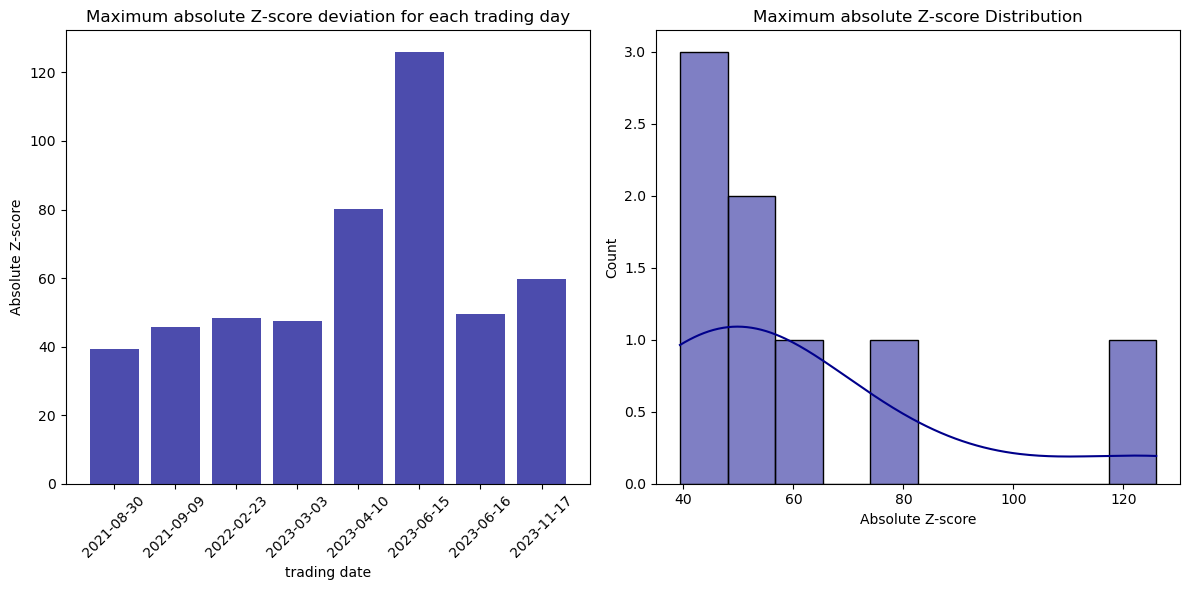


最极端的5个偏离案例:
日期: 2023-06-15, 股票代码: 688472, Z分数: -125.97
  订单价格: 0.13, 平均对数价格: 16.27, 订单数量: 37596
  -------------
日期: 2023-04-10, 股票代码: 688484, Z分数: -80.08
  订单价格: 0.01, 平均对数价格: 53.75, 订单数量: 17703
  -------------
日期: 2023-11-17, 股票代码: 300412, Z分数: -59.72
  订单价格: 4.54, 平均对数价格: 5.71, 订单数量: 7726
  -------------
日期: 2023-06-16, 股票代码: 300963, Z分数: -49.38
  订单价格: 10.55, 平均对数价格: 13.40, 订单数量: 6007
  -------------
日期: 2022-02-23, 股票代码: 300790, Z分数: -48.37
  订单价格: 25.00, 平均对数价格: 32.21, 订单数量: 6539
  -------------


In [2]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
from datetime import datetime, timedelta
import os
from tqdm import tqdm

def extract_bid_orders(trading_date):
    """提取指定交易日的买方订单数据"""
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    order_pth = f"/data/HighFreqData/Order/l2order/{date_str}.parquet"
    
    if not os.path.exists(order_pth):
        print(f"文件不存在: {order_pth}")
        return None
    
    conn = duckdb.connect(database=':memory:')
    
    query = f"""
    SELECT 
        security_code,
        order_price,
        order_volume,
        order_time
    FROM '{order_pth}'
    WHERE order_type = 'A'
        AND order_details = 'L'
        AND order_side = 1
        AND order_time >= 100000000 
        AND order_time < 143000000
    """
    
    try:
        orders_df = conn.execute(query).fetchdf()
        conn.close()
        
        if orders_df.empty:
            print(f"没有符合条件的数据: {date_str}")
            return None
            
        return orders_df
    except Exception as e:
        print(f"提取数据时出错 ({date_str}): {str(e)}")
        conn.close()
        return None

def find_max_deviation_orders(orders_df):
    """找出每只股票中偏离最大的订单"""
    if orders_df is None or orders_df.empty:
        return None
    
    # 存储每只股票最大偏离的订单
    max_dev_orders = []
    
    # 按股票分组计算
    for code, group in orders_df.groupby('security_code'):
        if len(group) < 10:  # 忽略订单数量太少的股票
            continue
            
        # 计算对数价格
        log_prices = np.log(group['order_price'])
        
        # 计算Z分数
        mean_log_price = log_prices.mean()
        std_log_price = log_prices.std()
        
        if std_log_price == 0:  # 避免除以零
            continue
            
        z_scores = (log_prices - mean_log_price) / std_log_price
        
        # 找出最大偏离(绝对值)的订单
        max_dev_idx = np.abs(z_scores).idxmax()
        max_dev_order = group.loc[max_dev_idx].copy()
        max_dev_order['z_score'] = z_scores[max_dev_idx]
        max_dev_order['mean_log_price'] = mean_log_price
        max_dev_order['std_log_price'] = std_log_price
        max_dev_order['order_count'] = len(group)
        
        max_dev_orders.append(max_dev_order)
    
    if not max_dev_orders:
        return None
        
    # 转换为DataFrame
    result_df = pd.DataFrame(max_dev_orders)
    
    # 找出Z分数绝对值最大的订单
    max_overall_idx = np.abs(result_df['z_score']).idxmax()
    max_overall_order = result_df.loc[max_overall_idx]
    
    return max_overall_order

def generate_random_dates(start_date, end_date, num_dates=10):
    """生成指定范围内的随机日期列表"""
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_range = (end - start).days
    if date_range <= 0:
        return []
    
    random_days = sorted(random.sample(range(date_range), min(num_dates, date_range)))
    random_dates = [start + timedelta(days=day) for day in random_days]
    
    return [date.strftime('%Y-%m-%d') for date in random_dates]

def analyze_date_range(start_date='2021-05-18', end_date='2024-12-31', num_sample_dates=15):
    """分析指定日期范围内的极端价格订单"""
    # 生成随机日期
    sample_dates = generate_random_dates(start_date, end_date, num_sample_dates)
    
    # 存储每个日期的最大偏离订单
    all_max_deviations = []
    
    # 分析每个日期
    for date in tqdm(sample_dates, desc="分析交易日"):
        orders_df = extract_bid_orders(date)
        if orders_df is not None:
            max_dev_order = find_max_deviation_orders(orders_df)
            if max_dev_order is not None:
                max_dev_order['trading_date'] = date
                all_max_deviations.append(max_dev_order)
    
    # 转换为DataFrame并排序
    if all_max_deviations:
        results_df = pd.DataFrame(all_max_deviations)
        results_df = results_df.sort_values(by='trading_date')
        return results_df
    else:
        return pd.DataFrame()

def analyze_all_stocks_deviation(trading_date):
    """分析指定日期所有股票的最大偏离情况"""
    orders_df = extract_bid_orders(trading_date)
    if orders_df is None:
        return None
    
    # 存储每只股票的最大偏离信息
    stock_deviations = []
    
    # 按股票分组计算
    for code, group in tqdm(orders_df.groupby('security_code'), desc=f"分析股票 ({trading_date})"):
        if len(group) < 10:  # 忽略订单数量太少的股票
            continue
            
        # 计算对数价格
        log_prices = np.log(group['order_price'])
        
        # 计算Z分数
        mean_log_price = log_prices.mean()
        std_log_price = log_prices.std()
        
        if std_log_price == 0:  # 避免除以零
            continue
            
        z_scores = (log_prices - mean_log_price) / std_log_price
        
        # 找出最大偏离(绝对值)的Z分数
        max_abs_z = np.abs(z_scores).max()
        
        stock_deviations.append({
            'security_code': code,
            'max_abs_z_score': max_abs_z,
            'order_count': len(group),
            'mean_log_price': mean_log_price,
            'std_log_price': std_log_price
        })
    
    if not stock_deviations:
        return None
        
    return pd.DataFrame(stock_deviations)

def visualize_max_deviations(results_df):
    """可视化最大偏离的分析结果"""
    if results_df.empty:
        print("没有数据可供可视化")
        return
    
    # 绘制Z分数的分布
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(results_df['trading_date'], np.abs(results_df['z_score']), color='darkblue', alpha=0.7)
    plt.title('Maximum absolute Z-score deviation for each trading day')
    plt.xlabel('trading date')
    plt.ylabel('Absolute Z-score')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.histplot(np.abs(results_df['z_score']), bins=10, kde=True, color='darkblue')
    plt.title('Maximum absolute Z-score Distribution')
    plt.xlabel('Absolute Z-score')
    
    plt.tight_layout()
    plt.show()
    
    # 打印最极端的几个案例
    extreme_cases = results_df.sort_values(by='z_score', key=abs, ascending=False).head(5)
    print("\n最极端的5个偏离案例:")
    for idx, row in extreme_cases.iterrows():
        print(f"日期: {row['trading_date']}, 股票代码: {row['security_code']}, Z分数: {row['z_score']:.2f}")
        print(f"  订单价格: {row['order_price']:.2f}, 平均对数价格: {np.exp(row['mean_log_price']):.2f}, 订单数量: {row['order_count']}")
        print("  -------------")

def visualize_single_day_deviations(deviations_df, trading_date):
    """可视化单个交易日所有股票的最大偏离情况"""
    if deviations_df is None or deviations_df.empty:
        print(f"没有{trading_date}的数据可供可视化")
        return
    
    plt.figure(figsize=(12, 8))
    
    # 绘制Z分数分布
    plt.subplot(2, 1, 1)
    sns.histplot(deviations_df['max_abs_z_score'], bins=50, kde=True)
    plt.title(f'{trading_date} All Stocks Maximum absolute Z-score Distributio')
    plt.xlabel('Maximum absolute Z-score')
    plt.ylabel('Stock Count')
    
    # 绘制散点图：订单数量与最大Z分数
    plt.subplot(2, 1, 2)
    plt.scatter(deviations_df['order_count'], deviations_df['max_abs_z_score'], 
                alpha=0.5, s=20, c='darkblue')
    plt.title('Order Volume vs Maximum absolute Z-score')
    plt.xlabel('Order Volume')
    plt.ylabel('Maximum absolute Z-score')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n{trading_date} 最大Z分数绝对值统计信息:")
    print(f"平均值: {deviations_df['max_abs_z_score'].mean():.2f}")
    print(f"中位数: {deviations_df['max_abs_z_score'].median():.2f}")
    print(f"95%分位数: {deviations_df['max_abs_z_score'].quantile(0.95):.2f}")
    print(f"99%分位数: {deviations_df['max_abs_z_score'].quantile(0.99):.2f}")
    print(f"最大值: {deviations_df['max_abs_z_score'].max():.2f}")
    
    # 打印最极端的几个案例
    extreme_stocks = deviations_df.sort_values(by='max_abs_z_score', ascending=False).head(5)
    print("\n最极端的5个股票:")
    for idx, row in extreme_stocks.iterrows():
        print(f"股票代码: {row['security_code']}, 最大Z分数: {row['max_abs_z_score']:.2f}, 订单数量: {row['order_count']}")

def main():
    # 设置随机种子以确保可重复性
    random.seed(42)
    
    print("分析方式选择:")
    print("1. 分析多个交易日的最大偏离订单")
    print("2. 分析单个交易日所有股票的偏离情况")
    
    choice = input("请选择分析方式 (1/2): ")
    
    if choice == '1':
        # 分析多个交易日
        print("\n分析多个交易日的最大偏离订单...")
        start_date = '2021-05-18'
        end_date = '2023-12-31'
        num_dates = 15
        
        results_df = analyze_date_range(start_date, end_date, num_dates)
        
        if not results_df.empty:
            visualize_max_deviations(results_df)
        else:
            print("没有找到符合条件的数据")
    
    elif choice == '2':
        # 分析单个交易日
        print("\n分析单个交易日所有股票的偏离情况...")
        
        # 选择一个随机日期
        sample_dates = generate_random_dates('2021-05-18', '2023-12-31', 1)
        if not sample_dates:
            print("生成随机日期失败")
            return
            
        trading_date = sample_dates[0]
        print(f"分析日期: {trading_date}")
        
        # 分析该日期所有股票的偏离情况
        deviations_df = analyze_all_stocks_deviation(trading_date)
        
        # 可视化结果
        visualize_single_day_deviations(deviations_df, trading_date)
    
    else:
        print("无效的选择")

if __name__ == "__main__":
    main()


分析方式选择:
1. 分析多个交易日的最大偏离订单
2. 分析单个交易日所有股票的偏离情况

分析单个交易日所有股票的偏离情况...
分析日期: 2023-03-03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析股票 (2023-03-03): 100%|██████████| 4922/4922 [00:02<00:00, 2406.63it/s]


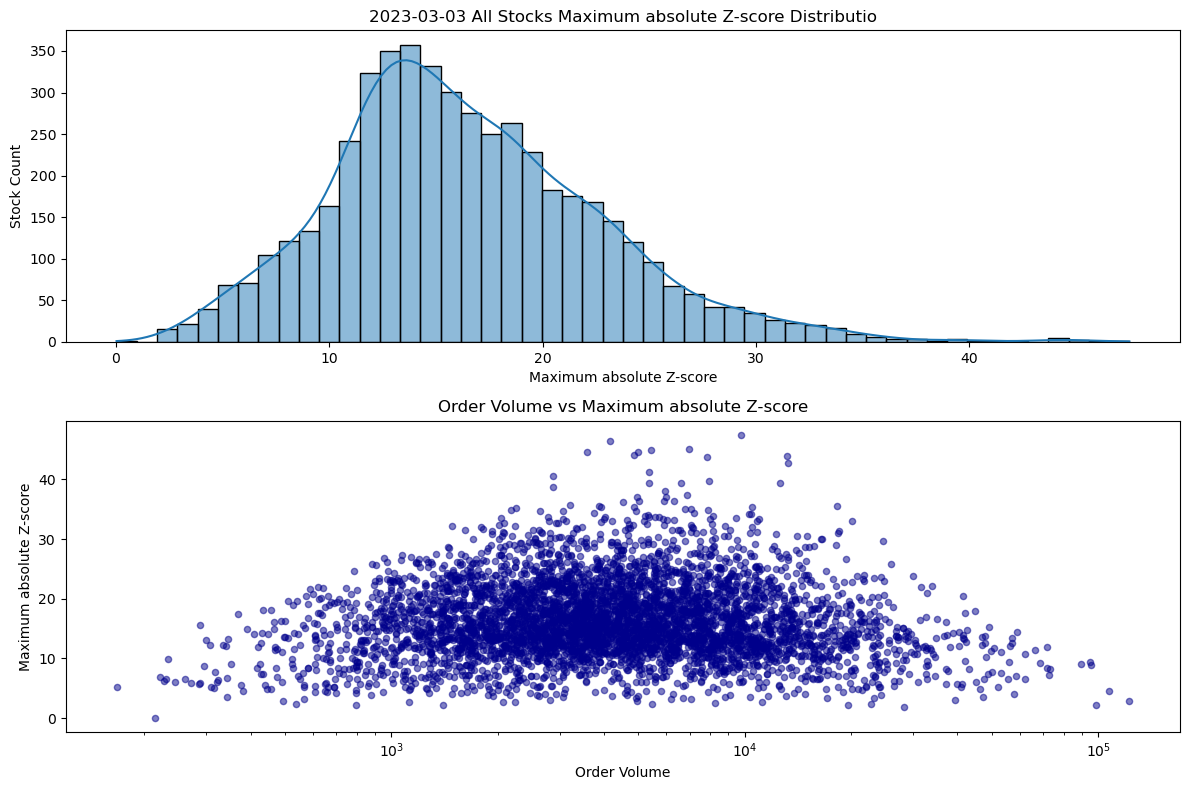


2023-03-03 最大Z分数绝对值统计信息:
平均值: 16.38
中位数: 15.62
95%分位数: 27.56
99%分位数: 33.73
最大值: 47.51

最极端的5个股票:
股票代码: 600350, 最大Z分数: 47.51, 订单数量: 9752
股票代码: 300640, 最大Z分数: 46.37, 订单数量: 4166
股票代码: 688522, 最大Z分数: 45.07, 订单数量: 6956
股票代码: 300163, 最大Z分数: 44.94, 订单数量: 5429
股票代码: 300272, 最大Z分数: 44.65, 订单数量: 3579


In [3]:
if __name__ == "__main__":
    main()

分析交易日 2022-05-10 的极端值对买方订单价格分歧度因子的影响...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

分析股票:   3%|▎         | 153/4662 [00:01<00:23, 191.45it/s]/tmp/ipykernel_3193931/3918502595.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_group['filtered_squared_dev'] = (filtered_group['log_price'] - filtered_weighted_avg) ** 2
分析股票:   5%|▍         | 216/4662 [00:01<00:18, 235.82it/s]/tmp/ipykernel_3193931/3918502595.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_group['filtered_squared_dev'] = (filtered_group['log_price'] - filtered_weighted_avg) ** 2
分析股票:   7%|▋         | 3

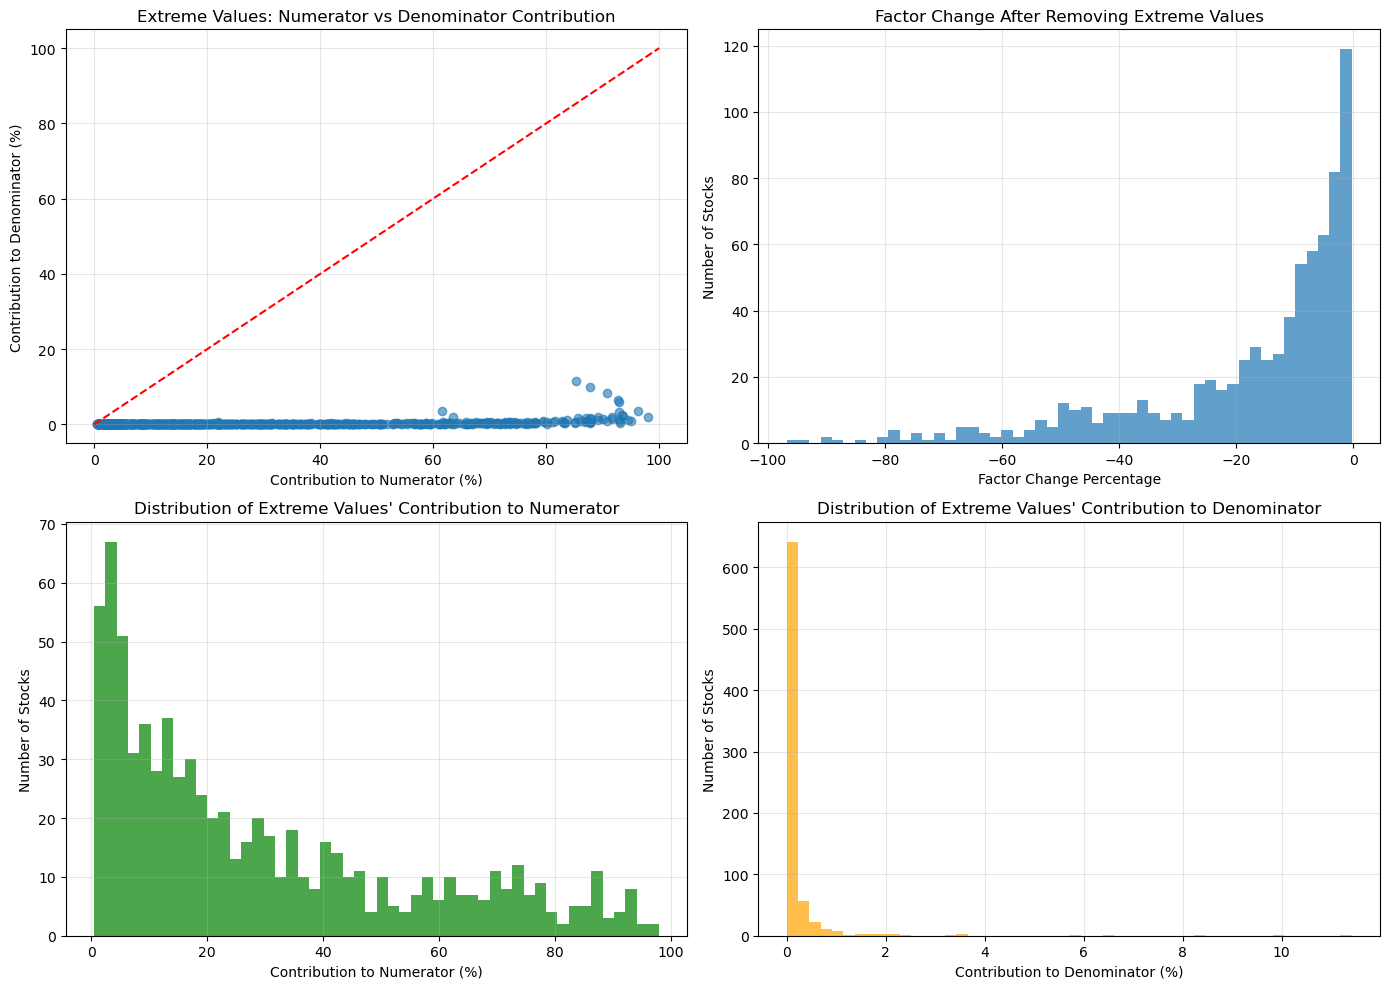


极端值对因子影响的统计信息:
有极端值的股票数量: 760
极端值对分子的平均贡献: 28.67%
极端值对分母的平均贡献: 0.21%
因子变化百分比的平均值: -17.80%

极端值对分子贡献更大的股票比例: 100.00%
极端值对分母贡献更大的股票比例: 0.00%


In [ ]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def extract_bid_orders(trading_date):
    """提取指定交易日的买方订单数据"""
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    order_pth = f"/data/HighFreqData/Order/l2order/{date_str}.parquet"
    
    if not os.path.exists(order_pth):
        print(f"文件不存在: {order_pth}")
        return None
    
    conn = duckdb.connect(database=':memory:')
    
    query = f"""
    SELECT 
        security_code,
        order_price,
        order_volume,
        order_time
    FROM '{order_pth}'
    WHERE order_type = 'A'
        AND order_details = 'L'
        AND order_side = 1
        AND order_time >= 100000000 
        AND order_time < 143000000
    """
    
    try:
        orders_df = conn.execute(query).fetchdf()
        conn.close()
        
        if orders_df.empty:
            print(f"没有符合条件的数据: {date_str}")
            return None
            
        return orders_df
    except Exception as e:
        print(f"提取数据时出错 ({date_str}): {str(e)}")
        conn.close()
        return None

def calculate_factor_with_without_extremes(orders_df, z_score_threshold=20):
    """计算有无极端值情况下的因子值"""
    results = []
    
    # 按股票分组计算
    for code, group in tqdm(orders_df.groupby('security_code'), desc="分析股票"):
        if len(group) < 10:  # 忽略订单数量太少的股票
            continue
        
        # 计算对数价格
        group['log_price'] = np.log(group['order_price'])
        
        # 计算加权平均对数价格
        weighted_avg_log_price = np.sum(group['log_price'] * group['order_volume']) / np.sum(group['order_volume'])
        
        # 计算Z分数
        group['deviation'] = group['log_price'] - weighted_avg_log_price
        mean_dev = group['deviation'].mean()
        std_dev = group['deviation'].std()
        
        if std_dev == 0:  # 避免除以零
            continue
            
        group['z_score'] = (group['deviation'] - mean_dev) / std_dev
        
        # 标记极端值
        group['is_extreme'] = np.abs(group['z_score']) > z_score_threshold
        
        # 计算原始因子值
        group['squared_dev'] = (group['log_price'] - weighted_avg_log_price) ** 2
        original_numerator = np.sum(group['squared_dev'] * group['order_volume'])
        original_denominator = np.sum(group['order_volume'])
        original_factor = np.sqrt(original_numerator / original_denominator)
        
        # 计算去除极端值后的因子值
        filtered_group = group[~group['is_extreme']]
        if len(filtered_group) < 5:  # 忽略过滤后订单太少的股票
            continue
            
        # 重新计算加权平均对数价格
        filtered_weighted_avg = np.sum(filtered_group['log_price'] * filtered_group['order_volume']) / np.sum(filtered_group['order_volume'])
        
        # 重新计算因子
        filtered_group['filtered_squared_dev'] = (filtered_group['log_price'] - filtered_weighted_avg) ** 2
        filtered_numerator = np.sum(filtered_group['filtered_squared_dev'] * filtered_group['order_volume'])
        filtered_denominator = np.sum(filtered_group['order_volume'])
        filtered_factor = np.sqrt(filtered_numerator / filtered_denominator)
        
        # 计算极端值对分子和分母的贡献
        extreme_group = group[group['is_extreme']]
        extreme_numerator_contribution = np.sum(extreme_group['squared_dev'] * extreme_group['order_volume']) / original_numerator if original_numerator > 0 else 0
        extreme_denominator_contribution = np.sum(extreme_group['order_volume']) / original_denominator if original_denominator > 0 else 0
        
        results.append({
            'security_code': code,
            'original_factor': original_factor,
            'filtered_factor': filtered_factor,
            'factor_change_pct': (filtered_factor - original_factor) / original_factor * 100 if original_factor > 0 else 0,
            'extreme_count': sum(group['is_extreme']),
            'total_count': len(group),
            'extreme_numerator_contribution': extreme_numerator_contribution * 100,  # 百分比
            'extreme_denominator_contribution': extreme_denominator_contribution * 100,  # 百分比
            'has_extremes': sum(group['is_extreme']) > 0
        })
    
    return pd.DataFrame(results)

def visualize_extreme_contributions(results_df):
    """可视化极端值对分子和分母的贡献"""
    # 只分析有极端值的股票
    has_extremes_df = results_df[results_df['has_extremes']].copy()
    
    if has_extremes_df.empty:
        print("没有找到含有极端值的股票")
        return
    
    plt.figure(figsize=(14, 10))
    
    # 绘制极端值对分子和分母的贡献比较
    plt.subplot(2, 2, 1)
    plt.scatter(has_extremes_df['extreme_numerator_contribution'], 
                has_extremes_df['extreme_denominator_contribution'],
                alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')  # Diagonal line
    plt.xlabel('Contribution to Numerator (%)')
    plt.ylabel('Contribution to Denominator (%)')
    plt.title('Extreme Values: Numerator vs Denominator Contribution')
    plt.grid(True, alpha=0.3)

    # Plot distribution of factor change percentage
    plt.subplot(2, 2, 2)
    plt.hist(has_extremes_df['factor_change_pct'], bins=50, alpha=0.7)
    plt.xlabel('Factor Change Percentage')
    plt.ylabel('Number of Stocks')
    plt.title('Factor Change After Removing Extreme Values')
    plt.grid(True, alpha=0.3)

    # Plot distribution of extreme values' contribution to numerator
    plt.subplot(2, 2, 3)
    plt.hist(has_extremes_df['extreme_numerator_contribution'], bins=50, alpha=0.7, color='green')
    plt.xlabel('Contribution to Numerator (%)')
    plt.ylabel('Number of Stocks')
    plt.title('Distribution of Extreme Values\' Contribution to Numerator')
    plt.grid(True, alpha=0.3)

    # Plot distribution of extreme values' contribution to denominator
    plt.subplot(2, 2, 4)
    plt.hist(has_extremes_df['extreme_denominator_contribution'], bins=50, alpha=0.7, color='orange')
    plt.xlabel('Contribution to Denominator (%)')
    plt.ylabel('Number of Stocks')
    plt.title('Distribution of Extreme Values\' Contribution to Denominator')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("\n极端值对因子影响的统计信息:")
    print(f"有极端值的股票数量: {len(has_extremes_df)}")
    print(f"极端值对分子的平均贡献: {has_extremes_df['extreme_numerator_contribution'].mean():.2f}%")
    print(f"极端值对分母的平均贡献: {has_extremes_df['extreme_denominator_contribution'].mean():.2f}%")
    print(f"因子变化百分比的平均值: {has_extremes_df['factor_change_pct'].mean():.2f}%")
    
    # 比较分子和分母贡献的大小
    numerator_larger = has_extremes_df['extreme_numerator_contribution'] > has_extremes_df['extreme_denominator_contribution']
    print(f"\n极端值对分子贡献更大的股票比例: {numerator_larger.mean() * 100:.2f}%")
    print(f"极端值对分母贡献更大的股票比例: {(1 - numerator_larger.mean()) * 100:.2f}%")

def main():
    # 选择一个交易日进行分析
    trading_date = '2022-05-10'  # 可以根据需要更改日期
    
    print(f"分析交易日 {trading_date} 的极端值对买方订单价格分歧度因子的影响...")
    
    # 提取订单数据
    orders_df = extract_bid_orders(trading_date)
    
    if orders_df is None or orders_df.empty:
        print("没有找到有效数据")
        return
    
    # 计算有无极端值的因子
    results_df = calculate_factor_with_without_extremes(orders_df, z_score_threshold=20)
    
    # 可视化结果
    visualize_extreme_contributions(results_df)

if __name__ == "__main__":
    main()
